In [159]:
! pip install keras-tuner --upgrade

In [160]:
# EDA for
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
from time import time
import optuna
from tqdm import tqdm
from datetime import datetime
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler
)

# Metrics
from sklearn.metrics import (
    mean_squared_error
)

from tensorflow.keras.metrics import RootMeanSquaredError

# Models

import keras_tuner
from keras import *
from scikeras.wrappers import KerasRegressor
from keras import Sequential
from keras.layers import (
    Dense, 
    Dropout,
)

from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

from sklearn.dummy import DummyRegressor
from sklearn.model_selection import (
    cross_val_score, 
    RepeatedKFold,
    train_test_split,
    GridSearchCV,
    KFold,
)
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from catboost import *

# Any
import warnings
warnings.filterwarnings('ignore')

In [161]:
class CFG:
    TARGET = 'nivel_y'
    N_FOLDS = 3
    RANDOM_STATE = 87

    TRAIN_PATH_1 = './data/2024_08_10 16_20_01.csv'
    TRAIN_PATH_2 = './data/2024_08_10 18_25_52.csv'

In [162]:
df_end = pd.read_csv(CFG.TRAIN_PATH_1)
df_start = pd.read_csv(CFG.TRAIN_PATH_2)

In [163]:
df = pd.concat([df_start, df_end], ignore_index=True)

In [164]:
df = df.loc[(df['watch_indicator'] != 'False') &
(df['watch_indicator'] != 'None')]
df = df.drop(columns=['time', 'watch_indicator', 'nivel_t', CFG.TARGET])

In [165]:
df = df.reset_index(drop=True)
for i in df.columns:
    if i not in [CFG.TARGET, 'temperature']:
        df[i] = df[i].interpolate()

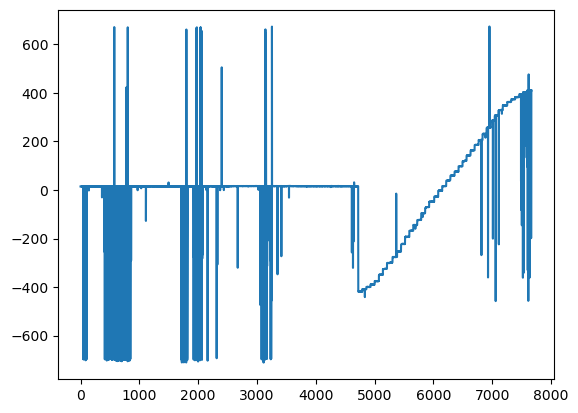

In [166]:
df['center_bubbles_px'].plot();

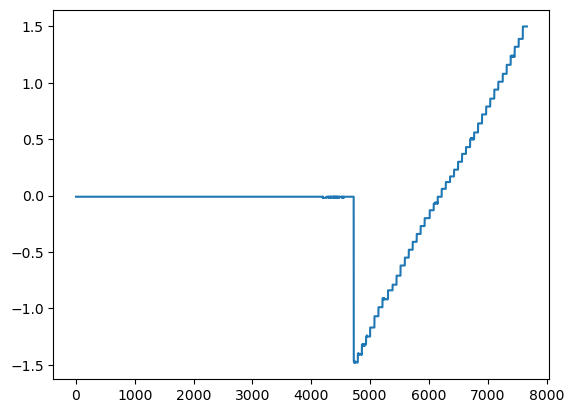

In [167]:
df['nivel_y'].plot();

In [168]:
def agg_features(df, suffix=''):
    X = pd.DataFrame()    
    X[suffix+"median"] = df.median(axis=1)
    X[suffix+"mean"] = df.mean(axis=1)
    X[suffix+"std"] = df.std(axis=1)
    X[suffix+"max"] = df.max(axis=1)
    X[suffix+"min"] = df.min(axis=1)
    return X

In [169]:
agg_features(df)

,median,mean,std,max,min
0,14.5,263.010825,435.050971,719.0,-182.0
1,14.5,264.117621,432.303846,719.0,-181.0
2,14.5,264.166165,431.990472,719.0,-181.0
3,14.5,264.292379,431.246613,719.0,-181.0
4,14.5,264.389466,431.230939,719.0,-181.0
...,...,...,...,...,...
7663,278.0,471.225121,226.555616,712.0,1.5
7664,281.0,471.662015,224.935387,712.0,1.5
7665,280.0,471.671723,225.702919,712.0,1.5
7666,279.0,471.030947,225.615297,712.0,1.5


In [170]:
df = df.join(agg_features(df), how='left')

In [171]:
df

,center_bubbles_px,nivel_y,temperature,1,2,3,4,5,6,7,...,96,97,98,99,100,median,mean,std,max,min
0,14.5,-0.01,25.6250,-182.0,712.0,-182.0,714.0,-181.0,716.0,-181.0,...,709.0,-150.0,692.0,-149.0,709.0,14.5,263.010825,435.050971,719.0,-182.0
1,14.5,-0.01,25.6250,-181.0,710.0,-181.0,717.0,-180.0,708.0,-180.0,...,708.0,-145.0,707.0,-145.0,690.0,14.5,264.117621,432.303846,719.0,-181.0
2,14.5,-0.01,25.6250,-181.0,709.0,-181.0,716.0,-180.0,717.0,-180.0,...,690.0,-145.0,707.0,-143.0,690.0,14.5,264.166165,431.990472,719.0,-181.0
3,14.5,-0.01,25.6250,-181.0,717.0,-181.0,710.0,-179.0,719.0,-179.0,...,707.0,-143.0,707.0,-142.0,690.0,14.5,264.292379,431.246613,719.0,-181.0
4,14.5,-0.01,25.6250,-181.0,717.0,-181.0,709.0,-179.0,719.0,-177.0,...,707.0,-144.0,690.0,-143.0,689.0,14.5,264.389466,431.230939,719.0,-181.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7663,410.0,1.50,26.6875,244.0,710.0,244.0,707.0,245.0,711.0,246.0,...,684.0,277.0,702.0,278.0,701.0,278.0,471.225121,226.555616,712.0,1.5
7664,411.0,1.50,26.6875,245.0,704.0,245.0,710.0,246.0,711.0,247.0,...,683.0,280.0,701.0,281.0,700.0,281.0,471.662015,224.935387,712.0,1.5
7665,410.0,1.50,26.6875,244.0,705.0,244.0,708.0,246.0,710.0,247.0,...,701.0,279.0,683.0,280.0,700.0,280.0,471.671723,225.702919,712.0,1.5
7666,410.0,1.50,26.6875,244.0,709.0,244.0,706.0,246.0,711.0,247.0,...,684.0,278.0,701.0,279.0,683.0,279.0,471.030947,225.615297,712.0,1.5


In [172]:
for i in df.columns:
    if i not in [CFG.TARGET, 'temperature']:
        print(i)
        df[i] = df[i].rolling(5).median()
        df[i].fillna(0, inplace=True)

center_bubbles_px
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
median
mean
std
max
min


In [173]:
features = df.drop([CFG.TARGET],axis=1)
target = df[CFG.TARGET]

# Cat

In [89]:
features_train, features_test, target_train, target_test = \
    train_test_split(features, target, train_size=0.75, random_state=CFG.RANDOM_STATE)

In [90]:
cat_model = CatBoostRegressor(loss_function='RMSE',
                                    iterations=1000,
                                    depth=10,
                                    learning_rate=0.1,
                                    random_state=CFG.RANDOM_STATE,
                                    task_type="GPU",
                                    early_stopping_rounds=100,
                                    )

In [91]:
cv_params = cat_model.get_params()
cv_data = cv(
    Pool(features_train, target_train),
    cv_params,
    verbose=False,
    plot=True,
    fold_count=3
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/3]
bestTest = 0.03498166484
bestIteration = 386
Training on fold [1/3]
bestTest = 0.01058638282
bestIteration = 331
Training on fold [2/3]
bestTest = 0.03283520525
bestIteration = 999


In [92]:
def build_catboost(trial):
    params = {
        'iterations':500,
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.01, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', .1, 1., log=True),
        'task_type': 'GPU',
        'loss_function':'RMSE'
    }

    model = CatBoostRegressor(**params, silent=True, random_state=CFG.RANDOM_STATE)
    cv_data = cv(
        Pool(features_train, target_train),
        model.get_params(),
        verbose=False
    )
    return np.min(cv_data['test-RMSE-mean'])

In [93]:
study = optuna.create_study(direction="minimize")
study.optimize(build_catboost, n_trials=10)

[I 2024-08-12 14:21:08,078] A new study created in memory with name: no-name-bdfe4f22-e84a-4251-9c7a-ff6dbd496bdb


Training on fold [0/3]
bestTest = 0.4662463466
bestIteration = 499
Training on fold [1/3]
bestTest = 0.4893768112
bestIteration = 499
Training on fold [2/3]


[I 2024-08-12 14:22:24,603] Trial 0 finished with value: 0.4738843558218806 and parameters: {'learning_rate': 0.00021839363884200487, 'depth': 10, 'l2_leaf_reg': 0.8294629841910904}. Best is trial 0 with value: 0.4738843558218806.


bestTest = 0.4660299097
bestIteration = 499
Training on fold [0/3]
bestTest = 0.03518755138
bestIteration = 499
Training on fold [1/3]
bestTest = 0.01165392582
bestIteration = 499
Training on fold [2/3]


[I 2024-08-12 14:23:41,623] Trial 1 finished with value: 0.027169814121245427 and parameters: {'learning_rate': 0.009479703937903124, 'depth': 10, 'l2_leaf_reg': 0.3222755998238693}. Best is trial 1 with value: 0.027169814121245427.


bestTest = 0.03466796516
bestIteration = 499
Training on fold [0/3]
bestTest = 0.3313333272
bestIteration = 499
Training on fold [1/3]
bestTest = 0.3475790496
bestIteration = 499
Training on fold [2/3]


[I 2024-08-12 14:24:27,576] Trial 2 finished with value: 0.3369151401193786 and parameters: {'learning_rate': 0.0009145781981482119, 'depth': 9, 'l2_leaf_reg': 0.10901148647405574}. Best is trial 1 with value: 0.027169814121245427.


bestTest = 0.3318330436
bestIteration = 499
Training on fold [0/3]
bestTest = 0.1938555589
bestIteration = 499
Training on fold [1/3]
bestTest = 0.2015562699
bestIteration = 499
Training on fold [2/3]


[I 2024-08-12 14:25:44,461] Trial 3 finished with value: 0.19657385163363897 and parameters: {'learning_rate': 0.002021044091447635, 'depth': 10, 'l2_leaf_reg': 0.17124610984414493}. Best is trial 1 with value: 0.027169814121245427.


bestTest = 0.1943097261
bestIteration = 499
Training on fold [0/3]
bestTest = 0.4895027838
bestIteration = 499
Training on fold [1/3]
bestTest = 0.5138471851
bestIteration = 499
Training on fold [2/3]


[I 2024-08-12 14:27:01,349] Trial 4 finished with value: 0.4975288193092293 and parameters: {'learning_rate': 0.00011813204768652522, 'depth': 10, 'l2_leaf_reg': 0.1838189309821132}. Best is trial 1 with value: 0.027169814121245427.


bestTest = 0.489236489
bestIteration = 499
Training on fold [0/3]
bestTest = 0.2963715857
bestIteration = 499
Training on fold [1/3]
bestTest = 0.3110084946
bestIteration = 499
Training on fold [2/3]


[I 2024-08-12 14:27:32,423] Trial 5 finished with value: 0.3014711829290906 and parameters: {'learning_rate': 0.0011526843683199966, 'depth': 8, 'l2_leaf_reg': 0.780162418388383}. Best is trial 1 with value: 0.027169814121245427.


bestTest = 0.2970334685
bestIteration = 499
Training on fold [0/3]
bestTest = 0.4360304321
bestIteration = 499
Training on fold [1/3]
bestTest = 0.4575604206
bestIteration = 499
Training on fold [2/3]


[I 2024-08-12 14:27:50,172] Trial 6 finished with value: 0.44322362691071193 and parameters: {'learning_rate': 0.00035914349351842076, 'depth': 6, 'l2_leaf_reg': 0.2011636618025906}. Best is trial 1 with value: 0.027169814121245427.


bestTest = 0.436080028
bestIteration = 499
Training on fold [0/3]
bestTest = 0.2628958943
bestIteration = 499
Training on fold [1/3]
bestTest = 0.2755182436
bestIteration = 499
Training on fold [2/3]


[I 2024-08-12 14:28:08,235] Trial 7 finished with value: 0.26741041629489876 and parameters: {'learning_rate': 0.0014131747139794221, 'depth': 6, 'l2_leaf_reg': 0.3381441095849098}. Best is trial 1 with value: 0.027169814121245427.


bestTest = 0.2638171109
bestIteration = 499
Training on fold [0/3]
bestTest = 0.4487475752
bestIteration = 499
Training on fold [1/3]
bestTest = 0.471428362
bestIteration = 499
Training on fold [2/3]


[I 2024-08-12 14:28:18,832] Trial 8 finished with value: 0.4563346839449653 and parameters: {'learning_rate': 0.000581494972185101, 'depth': 1, 'l2_leaf_reg': 0.24316557714127945}. Best is trial 1 with value: 0.027169814121245427.


bestTest = 0.4488281146
bestIteration = 499
Training on fold [0/3]
bestTest = 0.03566852708
bestIteration = 499
Training on fold [1/3]
bestTest = 0.01342903855
bestIteration = 499
Training on fold [2/3]


[I 2024-08-12 14:29:35,500] Trial 9 finished with value: 0.028189742009277624 and parameters: {'learning_rate': 0.00854025503364699, 'depth': 10, 'l2_leaf_reg': 0.15685411356706452}. Best is trial 1 with value: 0.027169814121245427.


bestTest = 0.0354716604
bestIteration = 499


In [94]:
print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

Best hyperparameters: {'learning_rate': 0.009479703937903124, 'depth': 10, 'l2_leaf_reg': 0.3222755998238693}
Best RMSE: 0.027169814121245427


In [95]:
X_train, X_valid, y_train, y_valid = train_test_split(
    features, target, test_size=0.33, random_state=CFG.RANDOM_STATE)


X_train_pool = Pool(X_train, y_train)
X_valid_pool = Pool(X_valid, y_valid)

In [96]:
cv_params = cat_model.get_params()
cv_params.update(study.best_params)
cv_params.update({'early_stopping_rounds': 100,
'iterations':10000})
cat_model_best = CatBoostRegressor(**cv_params).fit(X=X_train_pool, eval_set=X_valid_pool, 
                                                     verbose=False, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [97]:
pred = cat_model_best.predict(features)

In [98]:
mean_squared_error(target, cat_model_best.predict(features))

5.9211476223021534e-05

<Axes: >

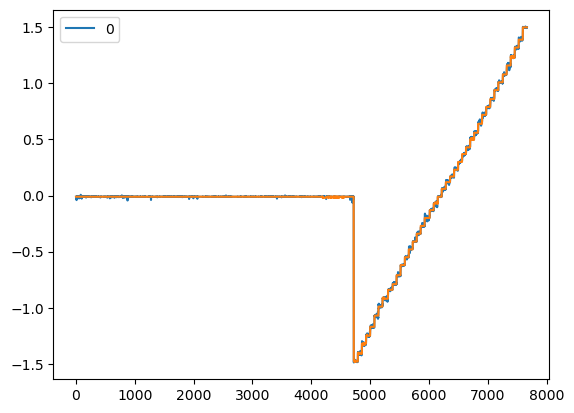

In [99]:
pd.DataFrame(pred).plot();target.plot()

In [100]:
dif = target - pred

In [101]:
dif.std()

0.007695400965382341

In [102]:
dif.mean()

1.762061287399826e-06

# Test Cat

In [141]:
test_df = pd.read_csv('./test2.csv')

In [142]:
test_df = test_df.loc[(test_df['watch_indicator'] != 'False') &
(test_df['watch_indicator'] != 'None')]
test_df = test_df.drop(columns=['time', 'watch_indicator', 'nivel_t', 'nivel_x'])

In [143]:
test_df = test_df.reset_index(drop=True)
for i in test_df.columns:
    if i not in [CFG.TARGET, 'temperature']:
        test_df[i] = test_df[i].interpolate()

In [144]:
test_df = test_df.join(agg_features(test_df), how='left')

In [145]:
for i in test_df.columns:
    if i not in [CFG.TARGET, 'temperature']:
        print(i)
        test_df[i] = test_df[i].rolling(5).median()
        test_df[i].fillna(0, inplace=True)

center_bubbles_px
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
median
mean
std
max
min


In [146]:
features = test_df.drop([CFG.TARGET],axis=1)
target = test_df[CFG.TARGET]

In [147]:
pred = cat_model_best.predict(features)

In [153]:
mean_squared_error(target, cat_model_best.predict(features))

0.0007399756936236056

<Axes: >

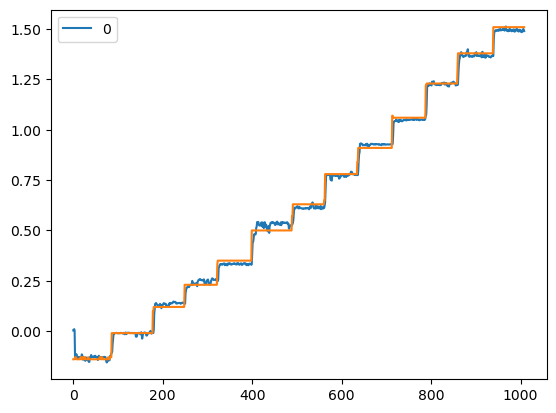

In [149]:
pd.DataFrame(pred).plot();target.plot()

In [150]:
dif = target - pred

In [151]:
dif.std()

0.026995134115999284

In [152]:
dif.mean()

0.0034584194098711135

In [156]:
cat_model_best.save_model('model_v_1_5')

# NN

In [174]:
features

,center_bubbles_px,temperature,1,2,3,4,5,6,7,8,...,96,97,98,99,100,median,mean,std,max,min
0,0.0,25.6250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
1,0.0,25.6250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
2,0.0,25.6250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
3,0.0,25.6250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
4,14.5,25.6250,-181.0,712.0,-181.0,714.0,-180.0,717.0,-180.0,709.0,...,707.0,-145.0,707.0,-143.0,690.0,14.5,264.166165,431.990472,719.0,-181.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7663,410.0,26.6875,244.0,707.0,244.0,709.0,245.0,710.0,245.0,706.0,...,683.0,280.0,701.0,281.0,691.0,281.0,471.225121,226.555616,712.0,1.5
7664,410.0,26.6875,244.0,707.0,244.0,710.0,245.0,711.0,246.0,711.0,...,683.0,280.0,701.0,281.0,691.0,281.0,471.225121,226.555616,712.0,1.5
7665,410.0,26.6875,244.0,705.0,244.0,710.0,246.0,711.0,247.0,711.0,...,683.0,280.0,700.5,281.0,700.0,281.0,471.662015,225.702919,712.0,1.5
7666,410.0,26.6875,244.0,709.0,244.0,708.0,246.0,711.0,247.0,711.0,...,684.0,279.0,701.0,280.0,700.0,280.0,471.225121,225.702919,712.0,1.5


In [175]:
scaler = MinMaxScaler()
features = scaler.fit_transform(features)

In [176]:
features_train, features_test, target_train, target_test = \
    train_test_split(features, target, train_size=0.75, random_state=CFG.RANDOM_STATE)

In [177]:
def build_model():
    model_nn = Sequential()
    model_nn.add(Dense(32, activation='tanh'))
    model_nn.add(Dense(1))
    model_nn.compile(optimizer=Adam(), 
                    loss='mean_squared_error', 
                    metrics=[RootMeanSquaredError()])
    return model_nn

In [178]:
model_nn = build_model()

model_nn.fit(
    features_train,
    target_train,
    epochs=100
)

Epoch 1/100
180/180 [==============================] - 0s 508us/step - loss: 0.0318 - root_mean_squared_error: 0.1782
Epoch 2/100
180/180 [==============================] - 0s 453us/step - loss: 0.0034 - root_mean_squared_error: 0.0582
Epoch 3/100
180/180 [==============================] - 0s 503us/step - loss: 0.0030 - root_mean_squared_error: 0.0551
Epoch 4/100
180/180 [==============================] - 0s 592us/step - loss: 0.0028 - root_mean_squared_error: 0.0531
Epoch 5/100
180/180 [==============================] - 0s 598us/step - loss: 0.0026 - root_mean_squared_error: 0.0509
Epoch 6/100
180/180 [==============================] - 0s 598us/step - loss: 0.0026 - root_mean_squared_error: 0.0511
Epoch 7/100
180/180 [==============================] - 0s 603us/step - loss: 0.0025 - root_mean_squared_error: 0.0496
Epoch 8/100
180/180 [==============================] - 0s 587us/step - loss: 0.0027 - root_mean_squared_error: 0.0522
Epoch 9/100
180/180 [==============================] - 0

In [179]:
def build_neural_network(hp):    
    model = Sequential()
    model.add(layers.Flatten())
    for i in range(hp.Int("num_layers", 1, 8)):
        model.add(
            layers.Dense(
                units=hp.Int(f"units_{i}", min_value=128, max_value=1024, step=64),
                activation=hp.Choice("activation", ["tanh"]),
            )
        )
    if hp.Boolean("dropout"):
        model.add(layers.Dropout(rate=0.35))
    model.add(layers.Dense(1))
    learning_rate = hp.Float("lr", min_value=1e-6, max_value=1e-2, sampling="log")
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='mean_squared_error', 
        metrics=[RootMeanSquaredError()]
    )
    return model

In [180]:
build_neural_network(keras_tuner.HyperParameters())

In [181]:
tuner = keras_tuner.RandomSearch(
    hypermodel=build_neural_network,
    objective=keras_tuner.Objective('val_root_mean_squared_error', 'min'),
    max_trials=5,
    executions_per_trial=3,
    overwrite=True,
)

In [182]:
tuner.search_space_summary()

Search space summary
Default search space size: 5
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 8, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 1024, 'step': 64, 'sampling': 'linear'}
activation (Choice)
{'default': 'tanh', 'conditions': [], 'values': ['tanh'], 'ordered': False}
dropout (Boolean)
{'default': False, 'conditions': []}
lr (Float)
{'default': 1e-06, 'conditions': [], 'min_value': 1e-06, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [183]:
X_train, X_val, y_train, y_val = \
    train_test_split(features, target, train_size=0.75, random_state=CFG.RANDOM_STATE)

In [184]:
tuner.search(X_train, y_train, epochs=100, validation_data=(X_val, y_val))

Trial 5 Complete [00h 04m 28s]
val_root_mean_squared_error: 0.5235622525215149

Best val_root_mean_squared_error So Far: 0.012325357335309187
Total elapsed time: 00h 11m 32s


In [185]:
best_NN = build_neural_network(tuner.get_best_hyperparameters()[0])

In [186]:
callback = EarlyStopping(monitor='loss', patience=100)

In [187]:
best_NN.fit(
    X_train,  
    y_train,
    epochs=10000,
    callbacks=[callback]
)

Epoch 1/10000
180/180 [==============================] - 1s 2ms/step - loss: 0.0304 - root_mean_squared_error: 0.1745
Epoch 2/10000
180/180 [==============================] - 0s 2ms/step - loss: 0.0053 - root_mean_squared_error: 0.0725
Epoch 3/10000
180/180 [==============================] - 0s 2ms/step - loss: 0.0049 - root_mean_squared_error: 0.0699
Epoch 4/10000
180/180 [==============================] - 0s 2ms/step - loss: 0.0046 - root_mean_squared_error: 0.0676
Epoch 5/10000
180/180 [==============================] - 0s 2ms/step - loss: 0.0043 - root_mean_squared_error: 0.0654
Epoch 6/10000
180/180 [==============================] - 0s 2ms/step - loss: 0.0040 - root_mean_squared_error: 0.0630
Epoch 7/10000
180/180 [==============================] - 0s 2ms/step - loss: 0.0037 - root_mean_squared_error: 0.0605
Epoch 8/10000
180/180 [==============================] - 0s 2ms/step - loss: 0.0034 - root_mean_squared_error: 0.0579
Epoch 9/10000
180/180 [==============================] -

In [188]:
ynew = best_NN.predict(features)
class_probabilities = np.hstack((1-ynew, ynew))

240/240 [==============================] - 0s 1ms/step


In [189]:
target

0      -0.01
1      -0.01
2      -0.01
3      -0.01
4      -0.01
        ... 
7663    1.50
7664    1.50
7665    1.50
7666    1.50
7667    1.50
Name: nivel_y, Length: 7668, dtype: float64

In [190]:
pred = pd.DataFrame(ynew)

In [191]:
np.sqrt(mean_squared_error(target, pred))

0.026182164995101342

<Axes: >

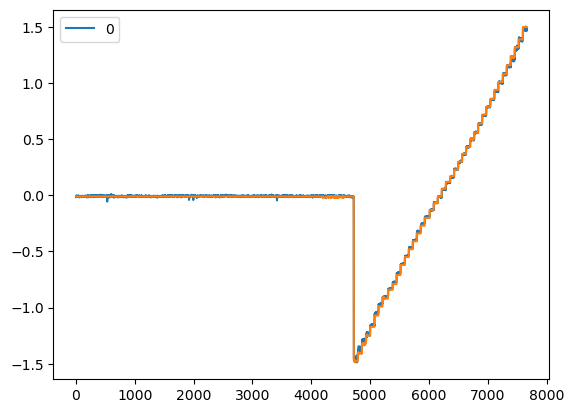

In [192]:
pred.plot(); target.plot()

In [193]:
dif = target - pred[0]

In [194]:
dif.std()

0.025986164382474093

In [195]:
dif.mean()

-0.0032113998970169882

# Test NN

In [198]:
test_df = pd.read_csv('./test/test1.csv')

In [199]:
test_df = test_df.loc[(test_df['watch_indicator'] != 'False') &
(test_df['watch_indicator'] != 'None')]
test_df = test_df.drop(columns=['time', 'watch_indicator', 'nivel_t', 'nivel_x'])

In [200]:
test_df = test_df.reset_index(drop=True)
for i in test_df.columns:
    if i not in [CFG.TARGET, 'temperature']:
        test_df[i] = test_df[i].interpolate()

In [201]:
test_df = test_df.join(agg_features(test_df), how='left')

In [202]:
for i in test_df.columns:
    if i not in [CFG.TARGET, 'temperature']:
        print(i)
        test_df[i] = test_df[i].rolling(5).median()
        test_df[i].fillna(0, inplace=True)

center_bubbles_px
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
median
mean
std
max
min


In [203]:
features = test_df.drop([CFG.TARGET],axis=1)
target = test_df[CFG.TARGET]

In [204]:
scaler = MinMaxScaler()
features = scaler.fit_transform(features)

In [205]:
pred = best_NN.predict(features)

19/19 [==============================] - 0s 833us/step


In [206]:
pred = pd.DataFrame(pred)

In [207]:
np.sqrt(mean_squared_error(target, pred))

0.3847204189031395

<Axes: >

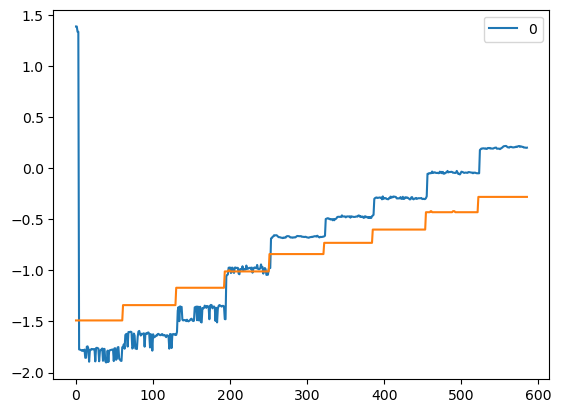

In [208]:
pd.DataFrame(pred).plot();target.plot()